In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_scatter_with_fit

In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
file_path = 'data_input_auto/人民币汇率.xlsx'
excel_data = pd.ExcelFile(file_path)
sheet = excel_data.parse('Sheet1')
sheet.rename(columns={'DataTime': 'Date'}, inplace=True)
sheet['Date'] = pd.to_datetime(sheet['Date'], errors='coerce')


In [4]:
file_path1 = 'data_output_auto/中国10年期国债收益率预测结果_2018年后.xlsx'
excel_data1 = pd.ExcelFile(file_path1)
sheet1 = excel_data1.parse('Sheet1')
sheet1.rename(columns={'DataTime': 'Date'}, inplace=True)
sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')

In [5]:
# 将两个数据框按日期合并,保留所有日期
merged_df = pd.merge(sheet, sheet1, on='Date', how='outer')
sheet = merged_df.copy()  


In [6]:
sheet = sheet[sheet['Date'] >= '2023-01-01']

In [7]:
sheet

,Date,USDCNH即期汇率,10年期美国国债收益率(插值预测),美元指数(预测),中国10年期国债收益率预测值
8080,2023-01-02,6.92675,NaN,103.7683,NaN
8081,2023-01-03,6.92405,3.79,104.6570,2.784351
8082,2023-01-04,6.90090,3.69,104.2669,2.786829
8083,2023-01-05,6.88900,3.71,105.1324,2.768017
8084,2023-01-06,6.82880,3.55,103.9104,2.830292
...,...,...,...,...,...
8666,2025-04-01,NaN,NaN,NaN,1.783181
8667,2025-04-02,NaN,NaN,NaN,1.783181
8668,2025-04-03,NaN,NaN,NaN,1.783181
8669,2025-04-04,NaN,NaN,NaN,1.783181


In [8]:
# 先对两列进行线性插值填充
sheet['10年期美国国债收益率(插值预测)'] = sheet['10年期美国国债收益率(插值预测)'].interpolate(method='linear')
sheet['中国10年期国债收益率预测值'] = sheet['中国10年期国债收益率预测值'].interpolate(method='linear')

# 计算中美利差
sheet['中美利差'] = sheet['中国10年期国债收益率预测值'] - sheet['10年期美国国债收益率(插值预测)']

sheet['中美利差_逆序'] = reverse_column(sheet, '中美利差')

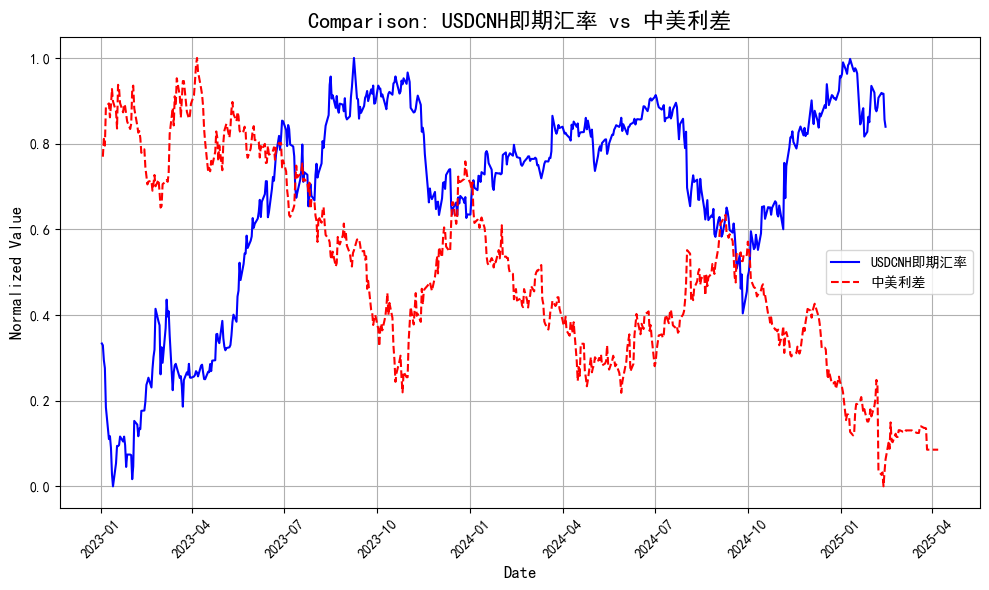

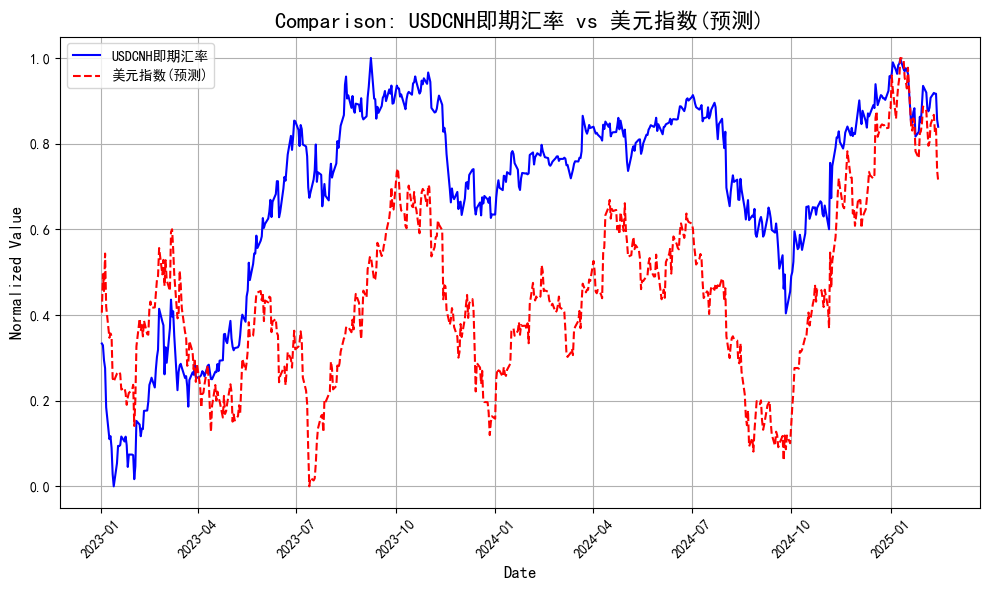

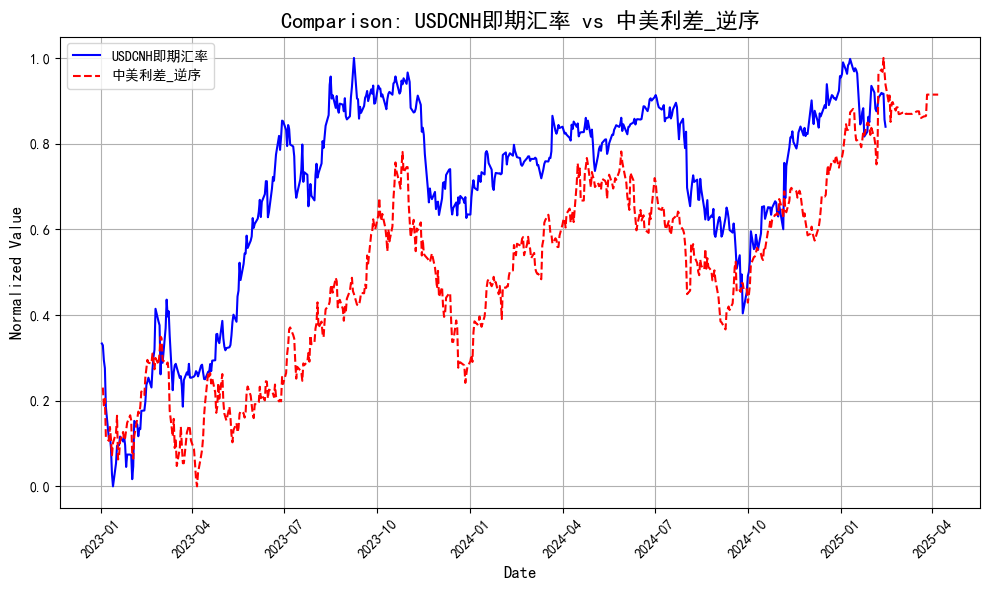

In [9]:
sheet_daily_plot = sheet.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='USDCNH即期汇率', 
    compare_cols=['中美利差','美元指数(预测)','中美利差_逆序']
)

In [10]:
last_day = sheet['Date'][sheet['USDCNH即期汇率'].last_valid_index()]
# 只将 last_day 之前的空缺值标记为需要删除
mask = (sheet['Date'] <= last_day) & (sheet['USDCNH即期汇率'].isna())
sheet = sheet[~mask]


In [11]:
sheet_daily = sheet.copy()

In [12]:
sheet_daily.columns

Index(['Date', 'USDCNH即期汇率', '10年期美国国债收益率(插值预测)', '美元指数(预测)', '中国10年期国债收益率预测值',
       '中美利差', '中美利差_逆序'],
      dtype='object')

In [13]:
# 划分训练集、测试集和未来数据
train_data = sheet_daily[sheet_daily['Date'] <= last_day]
test_period = 1
test_data = train_data[-test_period:]  
train_data = train_data[:-test_period]  
future_data = sheet_daily[sheet_daily['Date'] > last_day]

# 准备训练、测试和未来数据的输入和输出
X_train = train_data[['中美利差_逆序', '美元指数(预测)']]
y_train = train_data['USDCNH即期汇率']
X_test = test_data[['中美利差_逆序', '美元指数(预测)']]
y_test = test_data['USDCNH即期汇率']

X_future = future_data[['中美利差_逆序', '美元指数(预测)']]

In [14]:
# 初始化 MinMaxScaler
scaler = MinMaxScaler()

# 归一化特征数据
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

# 定义并训练 XGBRegressor 模型
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=120, learning_rate=0.08, max_depth=3, subsample=0.9, colsample_bytree=0.9)
xgb.fit(X_train_scaled, y_train)


# 训练集和测试集的预测
y_train_pred = xgb.predict(X_train_scaled)
y_test_pred = xgb.predict(X_test_scaled)

# 计算 MSE 和 R^2 分数
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train MSE: {train_mse}, Train R^2: {train_r2}")
print(f"Test MSE: {test_mse}, Test R^2: {test_r2}")

# 未来预测

'''
X_all = sheet_daily[sheet_daily['Date'] <= last_day][['中美利差_逆序', '美元指数(预测)']]
y_all = sheet_daily[sheet_daily['Date'] <= last_day]['USDCNH:即期汇率']

# 归一化所有历史特征数据
X_all_scaled = scaler.fit_transform(X_all)

# 使用所有历史数据重新训练模型
xgb.fit(X_all_scaled, y_all)
'''

y_future_pred = xgb.predict(X_future_scaled)

test_data = test_data.copy()
future_data = future_data.copy()

test_data.loc[:, '预测值'] = y_test_pred
future_data.loc[:, '预测值'] = y_future_pred

Train MSE: 0.003969282547997373, Train R^2: 0.8328364524732768
Test MSE: 0.0014577985299831313, Test R^2: nan


c:\Users\hzins\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


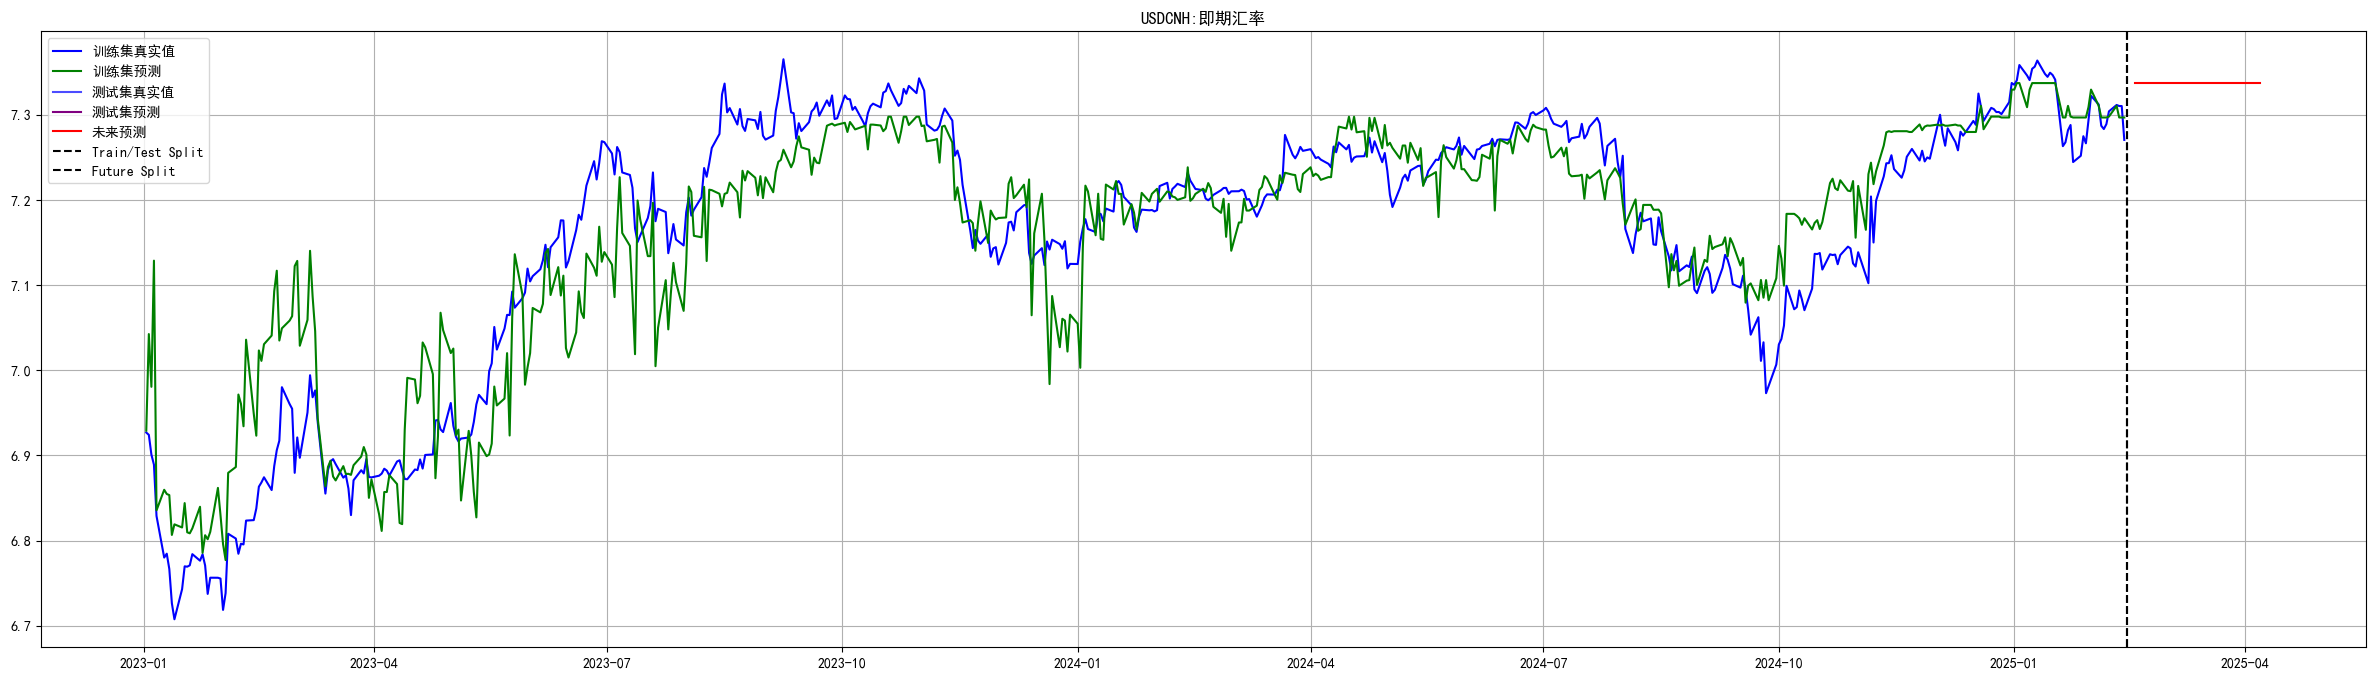

In [15]:
# 可视化
plt.figure(figsize=(30, 8))

plt.plot(train_data['Date'], y_train, label='训练集真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred, label='训练集预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集真实值', color='blue',alpha=0.7)
plt.plot(test_data['Date'], test_data['预测值'], label='测试集预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')

plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')
plt.title('USDCNH:即期汇率')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# 创建一个包含2018年之后数据的DataFrame
train_pred_df = pd.DataFrame({
    'Date': train_data['Date'],
    '预测值': y_train_pred
})
# train_pred_df = train_pred_df[train_pred_df['Date'].dt.year >= 2018]

test_pred_df = pd.DataFrame({
    'Date': test_data['Date'],
    '预测值': test_data['预测值']
})

future_pred_df = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值']
})

# 合并所有预测数据
all_predictions = pd.concat([train_pred_df, test_pred_df, future_pred_df])
all_predictions = all_predictions.rename(columns={'预测值': 'USDCNH即期汇率'})

all_predictions.head()


,Date,USDCNH:即期汇率_预测
8080,2023-01-02,6.928967
8081,2023-01-03,7.042364
8082,2023-01-04,6.980453
8083,2023-01-05,7.128549
8084,2023-01-06,6.835456


In [17]:
# 筛选2024年数据并按月取平均值
data_2024 = all_predictions[all_predictions['Date'].dt.year >= 2024].resample('ME', on='Date').mean()
data_2024 = data_2024.reset_index()
data_2024.to_csv('data_output_auto/人民币汇率2024年月度预测.csv',index=False, encoding='utf-8-sig')
print("数据已保存到 'data_output_auto/人民币汇率2024年月度预测.csv'")
print(data_2024)


数据已保存到 'data_output_auto/人民币汇率2024年月度预测.csv'
         Date  USDCNH:即期汇率_预测
0  2024-01-31        7.177723
1  2024-02-29        7.203287
2  2024-03-31        7.206287
3  2024-04-30        7.263655
4  2024-05-31        7.245351
5  2024-06-30        7.255778
6  2024-07-31        7.238149
7  2024-08-31        7.153859
8  2024-09-30        7.121208
9  2024-10-31        7.182430
10 2024-11-30        7.262910
11 2024-12-31        7.292055
12 2025-01-31        7.320137
13 2025-02-28        7.318274
14 2025-03-31        7.337008
15 2025-04-30        7.337008


In [18]:
future_pred_df_rename = future_pred_df.rename(columns={'预测值': 'USDCNH:即期汇率_预测'})
future_pred_df_rename.to_csv('data_output_auto/人民币汇率_未来日度预测.csv', index=False)
print('未来预测数据已保存到: data_output_auto/人民币汇率_未来日度预测.csv')

future_pred_df_rename.head()

未来预测数据已保存到: data_output_auto/人民币汇率_未来日度预测.csv


,Date,USDCNH:即期汇率_预测
8635,2025-02-17,7.337008
8636,2025-02-18,7.337008
8637,2025-02-19,7.337008
8638,2025-02-20,7.337008
8639,2025-02-21,7.337008


---

In [20]:
# 任务1: 合并训练集、测试集真实值和未来预测
# 获取2023年以后的训练集数据
train_data_2023 = train_data[train_data['Date'].dt.year >= 2023][['Date', 'USDCNH即期汇率']]
test_actual = test_data[['Date', 'USDCNH即期汇率']]

# 合并训练集和测试集的真实值
historical_actual = pd.concat([train_data_2023, test_actual])
historical_actual.columns = ['Date', '实际值']

# 获取未来预测值
future_pred = future_data[['Date', '预测值']]  # 修改这里的列名
future_pred.columns = ['Date', '预测值']

# 合并所有数据
merged_df = pd.merge(historical_actual, future_pred, on='Date', how='outer')
merged_df = merged_df.sort_values('Date', ascending=False)

# 将日期格式转换为年/月/日格式
merged_df['Date'] = merged_df['Date'].dt.strftime('%Y/%m/%d')

# 保存到Excel
merged_df.to_excel('eta/人民币汇率_合并数据.xlsx', index=False,float_format='%.2f')
merged_df

,Date,实际值,预测值
590,2025/04/07,NaN,7.337008
589,2025/04/04,NaN,7.337008
588,2025/04/03,NaN,7.337008
587,2025/04/02,NaN,7.337008
586,2025/04/01,NaN,7.337008
...,...,...,...
4,2023/01/06,6.82880,NaN
3,2023/01/05,6.88900,NaN
2,2023/01/04,6.90090,NaN
1,2023/01/03,6.92405,NaN


In [21]:
# 任务2: 生成月度数据
# 获取2023年以后的实际值
actual_values = pd.concat([
    train_data[train_data['Date'].dt.year >= 2023][['Date', 'USDCNH即期汇率']],
    test_data[['Date', 'USDCNH即期汇率']]
])
actual_values.columns = ['Date', '实际值']

# 创建包含2024年及以后训练集预测值的DataFrame
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred[train_data['Date'].dt.year >= 2024]
})

# 重新构建predictions DataFrame
predictions = pd.concat([
    train_pred_2024,
    test_data[['Date', '预测值']],
    future_data[['Date', '预测值']]
], ignore_index=True)

# 重新合并实际值和预测值
monthly_df = pd.merge(actual_values, predictions, on='Date', how='outer')

# 转换为月度数据
monthly_df['Date'] = pd.to_datetime(monthly_df['Date'])
monthly_df.set_index('Date', inplace=True)
monthly_df = monthly_df.resample('ME').mean()
monthly_df.reset_index(inplace=True)
monthly_df = monthly_df.sort_values('Date', ascending=False)
# 将日期格式转换为年/月/日格式
monthly_df['Date'] = monthly_df['Date'].dt.strftime('%Y/%m/%d')

# 保存月度数据
monthly_df.to_excel('eta/人民币汇率_月度数据.xlsx', index=False,float_format='%.2f')
monthly_df.head()

,Date,实际值,预测值
27,2025/04/30,NaN,7.337008
26,2025/03/31,NaN,7.337008
25,2025/02/28,7.293550,7.318274
24,2025/01/31,7.316276,7.320137
23,2024/12/31,7.293230,7.292055


---

In [22]:
# 创建新的DataFrame
interest_diff_df = pd.DataFrame()

# 添加真实值(last_day及之前的数据)
interest_diff_df = pd.concat([
    interest_diff_df,
    pd.DataFrame({
        'Date': sheet_daily[sheet_daily['Date'] <= last_day]['Date'],
        '真实值': sheet_daily[sheet_daily['Date'] <= last_day]['中美利差']
    })
])

# 添加预测值(last_day之后的数据)
interest_diff_df = pd.concat([
    interest_diff_df,
    pd.DataFrame({
        'Date': sheet_daily[sheet_daily['Date'] > last_day]['Date'],
        '预测值': sheet_daily[sheet_daily['Date'] > last_day]['中美利差']
    })
])

# 按日期排序
interest_diff_df = interest_diff_df.sort_values('Date',ascending=False)

# 显示结果
interest_diff_df.head()

,Date,真实值,预测值
8670,2025-04-07,NaN,-2.686819
8669,2025-04-04,NaN,-2.686819
8668,2025-04-03,NaN,-2.686819
8667,2025-04-02,NaN,-2.686819
8666,2025-04-01,NaN,-2.686819
